In [1]:
# импорт необходимых библеотек
from pony.orm import *
import getpass
import psycopg2
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

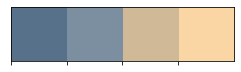

In [2]:
# задание палитры цветов
colors = ['#567189', '#7B8FA1', '#CFB997', '#FAD6A5']
sns.palplot(sns.color_palette(colors))

In [120]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    
    """ функция создания пользовательского
            масштабируемого цвета """
    
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [143]:
# задание палитры цветов
c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('slategray') , 0.25, c('slategray'), c('darkgray'), 0.50, \
     c('darkgray'), c('tan'), 0.75, c('tan'), c('wheat')])

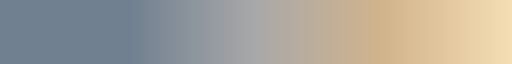

In [144]:
rvb

# Подключение к базе данных 'Sentiment'

In [3]:
# безопасно запрашиваем ввод пароля в CLI
password = getpass.getpass(prompt="Введите секретный пароль:")

Введите секретный пароль:········


In [4]:
# создание подключения к базе данны
connect = psycopg2.connect(database='sentiment',
                           user='postgres',
                           password=password,
                           host='127.0.0.1',
                           port='5432')

In [5]:
# создание объекта курсора подключения к базе данных
cursor = connect.cursor()

# Исследовательский анализ данных

[Модель данных](https://editor.ponyorm.com/user/RusLat/sentiment/designer)

<img src='images/sentiment.png'>

In [6]:
# распределение количества уникальных фильмов
cursor.execute("""SELECT title_id, COUNT(title_id) AS count  
                  FROM sentiment
                  GROUP BY title_id
                  ORDER BY count DESC;""")
titles = cursor.fetchall()
# преобразование в DataFrame
df_titles = pd.DataFrame(titles, columns=[_.name for _ in cursor.description])
df_titles.head()

,title_id,count
0,13694,30
1,12162,30
2,9879,30
3,9881,30
4,407,30


In [7]:
# сводные описательные статистики количества уникальных фильмов
df_titles[['count']].describe().T

,count,mean,std,min,25%,50%,75%,max
count,14127.0,7.078644,7.927623,1.0,2.0,4.0,8.0,30.0


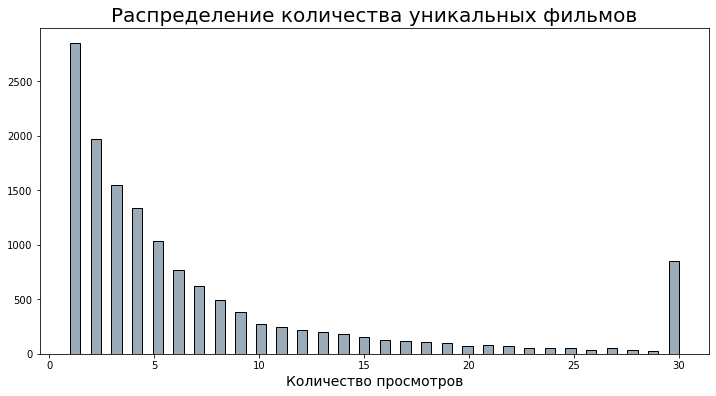

In [8]:
# визуализация распределения количества уникальных фильмов
plt.figure(figsize=(12,6))
sns.histplot(data=df_titles['count'], color=colors[1])
plt.title('Распределение количества уникальных фильмов', size = 20)
plt.xlabel('Количество просмотров', size = 14)
plt.ylabel('')
plt.show()

В основном фильмы имеею **от 1 до 5** просмотров. \
Так же есть фильмы имеющие **30**

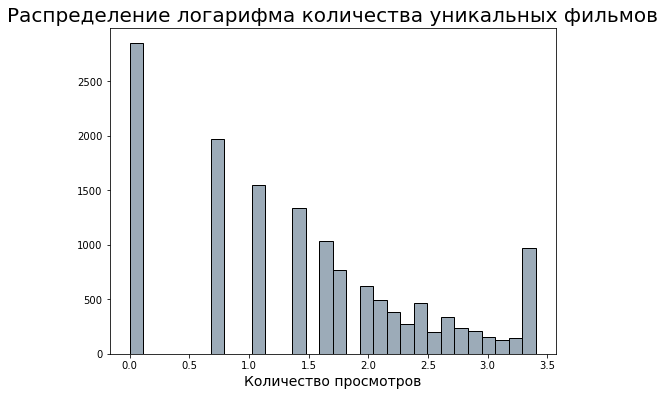

In [9]:
# визуализация распределения количества уникальных фильмов
plt.figure(figsize=(8,6))
sns.histplot(data=np.log(df_titles['count']), color=colors[1])
plt.title('Распределение логарифма количества уникальных фильмов', size = 20)
plt.xlabel('Количество просмотров', size = 14)
plt.ylabel('')
plt.show()

In [432]:
# распределение рейтинга фильмов
cursor.execute("""SELECT rating, label_name  
                  FROM sentiment
                  INNER JOIN label on label.id = sentiment.label_id
                  WHERE rating > 0;""")
ratings = cursor.fetchall()
# преобразование в DataFrame
df_ratings = pd.DataFrame(ratings, columns=[_.name for _ in cursor.description])
df_ratings.head()

,rating,label_name
0,8,pos
1,8,pos
2,10,pos
3,7,pos
4,10,pos


In [433]:
# сводные описательные статистики рейтинга
df_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,50000.0,5.49534,3.478721,1.0,2.0,5.5,9.0,10.0


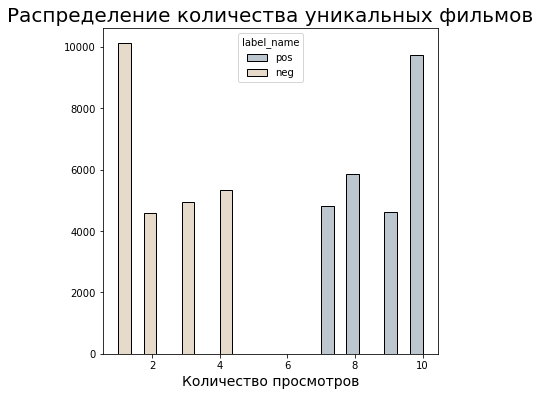

In [438]:
# визуализация распределения рейтинга фильмов
plt.figure(figsize=(6,6))
ax = sns.histplot(data=df_ratings, x='rating', palette=sns.color_palette(colors[1:3]), hue='label_name')
plt.title('Распределение количества уникальных фильмов', size = 20)
plt.xlabel('Количество просмотров', size = 14)
sns.move_legend(ax, "upper center")
plt.ylabel('')
plt.show()

Из распределения видно, что большинство **негативных** отзывов имеют рейтинг **1**, \
а **положительные** отзывы имеют рейтниг **10** \
Так же видно, что отсутствует рейтинг равный **5** или **6** \
Сам рейтинг имеет **целочисленное** значение

In [13]:
# вывод типа данных
cursor.execute("""SELECT label_name \
                  FROM sentiment
                  INNER JOIN label ON label.id = sentiment.label_id;""")
labels = cursor.fetchall()
# преобразование в DataFrame
df_labels = pd.DataFrame(labels, columns=[_.name for _ in cursor.description])
df_labels.head()

,label_name
0,pos
1,pos
2,pos
3,pos
4,pos


In [14]:
# распределения данных для обучения и теста модели
df_labels.value_counts()

label_name
unsup         50000
neg           25000
pos           25000
dtype: int64

В данных присутствует по **25 000** положительных и негативных комментраиев (отзывов), \
а также **50 000** комментариев (отзывов) без разметки данных

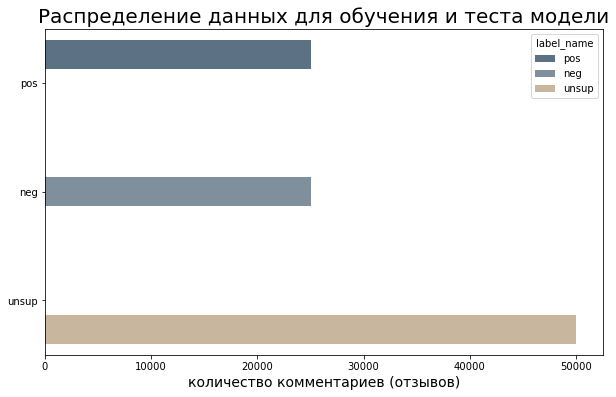

In [15]:
# визуализация распределения данных для обучения и теста модели
plt.figure(figsize=(10,6))
sns.countplot(y=df_labels['label_name'], hue=df_labels['label_name'], \
              palette=sns.color_palette(colors[:3]))
plt.title('Распределение данных для обучения и теста модели', size = 20)
plt.xlabel('количество комментариев (отзывов)', size = 14)
plt.ylabel('')
plt.show()

Дисбаланса в классах данных **нет**

In [16]:
# типичные положительные комментарии (отзывы)
cursor.execute("""SELECT review \
                  FROM sentiment
                  INNER JOIN label ON label.id = sentiment.label_id
                  WHERE label_name = 'pos'
                  LIMIT 3;""")
cursor.fetchall()

[('Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',),
 ('Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything

In [17]:
# типичные негативные комментарии (отзывы)
cursor.execute("""SELECT review \
                  FROM sentiment
                  INNER JOIN label ON label.id = sentiment.label_id
                  WHERE label_name = 'neg'
                  LIMIT 3;""")
cursor.fetchall()

[('I didn\'t know much about this movie before I watched it, but I heard it had something to do with quantum physics so I was interested. What I didn\'t know is that this is NOT ACTUALLY A STORY but a bunch of New-Age blowhards who love the sound of their own voice talking about how little they know about basic quantum mechanics. I say it belongs more in the Documentary category than Comedy or Drama.<br /><br />Marlee Matlin is in the movie, in order to give this New Age symposium *some* sort of a storyline. Her portions of the film feel horribly tacked on and are meant to display the speaker\'s thoughts so we won\'t die of boredom. Matlin has a real job as a photographer, unlike the New Age hippie that crashes on her couch. We get to listen to nameless people ramble on about what quantum physics all "means" to them. The one bright spot in this movie was the speaker from India (I assume), but I think he showed up for the wrong film.<br /><br />It looks like Barbara Eden really let hers

В комментариях (отзывах) присутствует **html** разметка и **эмоции** 

In [153]:
# вывод комментариев (отзывов)
cursor.execute("""SELECT label_name, review, rating \
                  FROM sentiment
                  INNER JOIN label ON label.id = sentiment.label_id
                  WHERE rating > 0;""")
reviews = cursor.fetchall()
# преобразование в DataFrame
df_reviews = pd.DataFrame(reviews, columns=[_.name for _ in cursor.description])
df_reviews.head()

,label_name,review,rating
0,pos,"I do try not to take IMDb ratings to heart, bu...",8
1,pos,"I saw this when it first came to video, my lit...",8
2,pos,its great i loved it ha cause i love dinosaurs...,10
3,pos,"I wouldn't call ""We're Back! A Dinosaur's Stor...",7
4,pos,this was a personal favorite of mine when i wa...,10


In [247]:
# функция очистка текста от html разметки
def preprocessor_html(text):

    text = re.sub(r'<[^>]+>', '', text)
    
    return text

In [252]:
df_reviews['review_html_clean'] = df_reviews['review'].map(preprocessor_html)

In [254]:
# количество символов в комментарии (отзыве)
df_reviews['review_len'] = df_reviews['review_html_clean'].map(len)

In [255]:
# расчет сводных статистик количества символов в комментарии (отзыве)
df_reviews.groupby('label_name')['review_len'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
neg,25000.0,1269.07492,927.030533,32.0,695.0,956.0,1536.00,8681.0
pos,25000.0,1301.27144,1013.092734,65.0,682.0,951.0,1582.25,13584.0


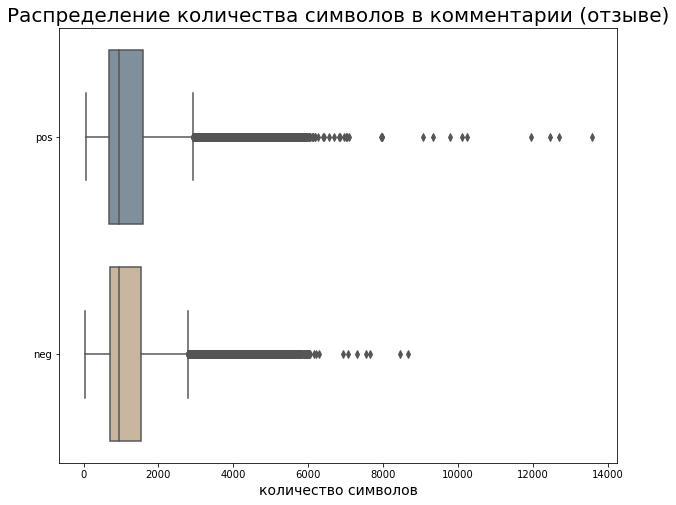

In [256]:
# визуализация распределения количества символов в комментарии (отзыве)
plt.figure(figsize=(10,8))
sns.boxplot(data=df_reviews, x="review_len", y="label_name", palette=sns.color_palette(colors[1:3]))
plt.title('Распределение количества символов в комментарии (отзыве)', size = 20)
plt.xlabel('количество символов', size = 14)
plt.ylabel('')
plt.show()

В отдельных **положительных** комментариях наблюдаются выбросы по количеству символов

In [257]:
# количество слов в комментарии (отзыве)
df_reviews['review_word_count'] = df_reviews['review_html_clean'].apply(lambda x: len(x.split()))

In [258]:
# расчет сводных статистик количества слов в комментарии (отзыве)
df_reviews.groupby('label_name')['review_word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
neg,25000.0,225.29808,161.842820,4.0,126.0,171.0,273.0,1474.0
pos,25000.0,228.92608,174.455784,10.0,123.0,170.0,278.0,2450.0


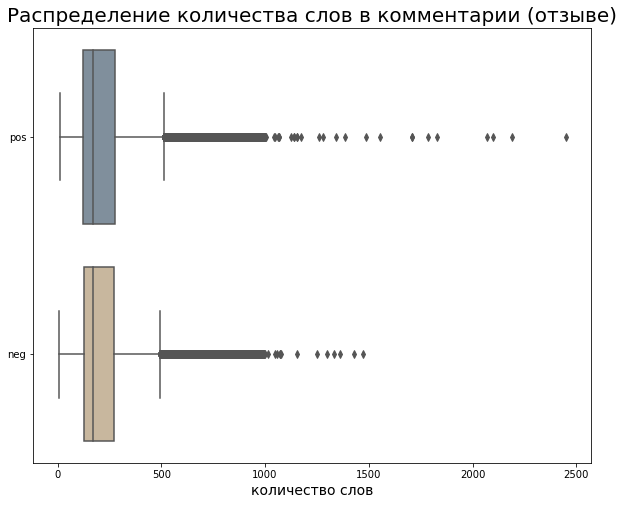

In [259]:
# визуализация распределения количества слов в комментарии (отзыве)
plt.figure(figsize=(10,8))
sns.boxplot(data=df_reviews, x="review_word_count", y="label_name", palette=sns.color_palette(colors[1:3]))
plt.title('Распределение количества слов в комментарии (отзыве)', size = 20)
plt.xlabel('количество слов', size = 14)
plt.ylabel('')
plt.show()

В отдельных **положительных** комментариях наблюдаются выбросы по количеству слов

In [166]:
#pip install -U textblob

In [167]:
from textblob import TextBlob

In [168]:
# функция подсчета количества предложений в комментарии (отзыве)
def review_sentences(review):
    
    blob = TextBlob(review)
    
    return len(blob.sentences)

In [260]:
# подсчет количества предложений в комментарии (отзыве)
df_reviews['review_sentences'] = df_reviews['review_html_clean'].map(review_sentences)

In [261]:
# расчет сводных статистик количества предложений в комментарии (отзыве)
df_reviews.groupby('label_name')['review_sentences'].describe()

,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
neg,25000.0,11.03652,7.883405,1.0,6.0,9.0,13.0,126.0
pos,25000.0,10.46612,7.632084,1.0,6.0,9.0,13.0,147.0


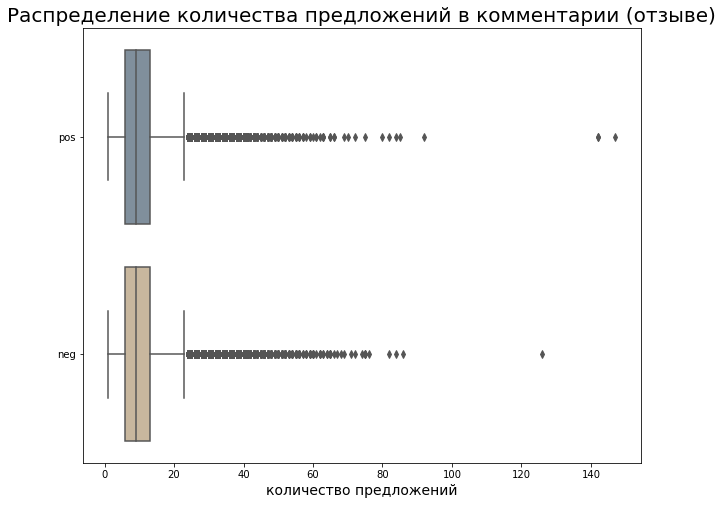

In [262]:
# визуализация распределения количества предложений в комментарии (отзыве)
plt.figure(figsize=(10,8))
sns.boxplot(data=df_reviews, x="review_sentences", y="label_name", palette=sns.color_palette(colors[1:3]))
plt.title('Распределение количества предложений в комментарии (отзыве)', size = 20)
plt.xlabel('количество предложений', size = 14)
plt.ylabel('')
plt.show()

In [263]:
# функция анализа комментария (отзыва)
def review_sentiment(review):
    
    blob = TextBlob(review)
    
    return blob.sentiment

In [264]:
# анализ комментария (отзыва)
df_reviews['review_sentiment'] = df_reviews['review_html_clean'].map(review_sentiment)

In [265]:
df_reviews['review_polarity'] = df_reviews['review_sentiment'].apply(lambda x: x.polarity)

In [266]:
df_reviews['review_subjectivity'] = df_reviews['review_sentiment'].apply(lambda x: x.subjectivity)

In [267]:
# вывод данных
df_reviews.head()

,label_name,review,rating,review_html_clean,review_len,review_word_count,review_sentences,review_sentiment,review_polarity,review_subjectivity
0,pos,"I do try not to take IMDb ratings to heart, bu...",8,"I do try not to take IMDb ratings to heart, bu...",1954,357,19,"(0.3358035714285714, 0.6402579365079367)",0.335804,0.640258
1,pos,"I saw this when it first came to video, my lit...",8,"I saw this when it first came to video, my lit...",2225,419,9,"(0.10124999999999999, 0.49913194444444436)",0.101250,0.499132
2,pos,its great i loved it ha cause i love dinosaurs...,10,its great i loved it ha cause i love dinosaurs...,766,166,1,"(0.31616071428571424, 0.6617857142857144)",0.316161,0.661786
3,pos,"I wouldn't call ""We're Back! A Dinosaur's Stor...",7,"I wouldn't call ""We're Back! A Dinosaur's Stor...",973,167,10,"(0.2323529411764706, 0.4180672268907563)",0.232353,0.418067
4,pos,this was a personal favorite of mine when i wa...,10,this was a personal favorite of mine when i wa...,651,115,5,"(0.2010416666666667, 0.5108333333333333)",0.201042,0.510833


In [268]:
# рассчет корреляции в данных
reviews_corr = df_reviews.corr(method='spearman')
reviews_corr

,rating,review_len,review_word_count,review_sentences,review_polarity,review_subjectivity
rating,1.000000,-0.011351,-0.015816,-0.049725,0.609399,0.006497
review_len,-0.011351,1.000000,0.993350,0.746196,-0.079298,-0.129877
review_word_count,-0.015816,0.993350,1.000000,0.762282,-0.081085,-0.129775
review_sentences,-0.049725,0.746196,0.762282,1.000000,-0.078932,-0.046416
review_polarity,0.609399,-0.079298,-0.081085,-0.078932,1.000000,0.040589
review_subjectivity,0.006497,-0.129877,-0.129775,-0.046416,0.040589,1.000000


In [269]:
df_reviews.corr()

,rating,review_len,review_word_count,review_sentences,review_polarity,review_subjectivity
rating,1.000000,0.014441,0.008631,-0.039290,0.594732,0.009970
review_len,0.014441,1.000000,0.996719,0.809784,-0.049547,-0.113381
review_word_count,0.008631,0.996719,1.000000,0.822256,-0.052163,-0.113699
review_sentences,-0.039290,0.809784,0.822256,1.000000,-0.056652,-0.051386
review_polarity,0.594732,-0.049547,-0.052163,-0.056652,1.000000,0.038738
review_subjectivity,0.009970,-0.113381,-0.113699,-0.051386,0.038738,1.000000


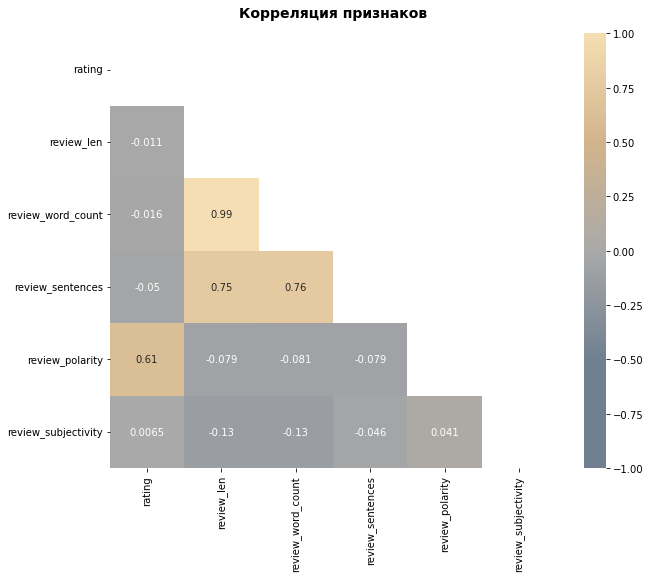

In [270]:
# визуализация корреляции признаков
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(reviews_corr, dtype=bool))
df_train_corr_heatmap = sns.heatmap(reviews_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap=rvb)
df_train_corr_heatmap.set_title('Корреляция признаков', fontweight='bold', \
                                fontdict={'fontsize':14}, pad=16)
plt.show()

Наблюдаяется **умеренная зависимость** ранговая корреляция рейтинга с полярностью комментария (отзыва)

In [271]:
# генерация случайного шума
noise = np.random.random(size=len(df_reviews))

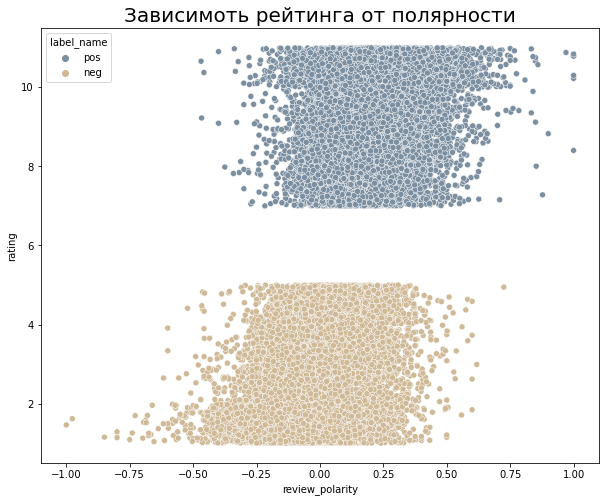

In [272]:
# визуализация зависимости рейтинга от полярности
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_reviews, x="review_polarity", y=df_reviews["rating"] + noise, \
                hue="label_name", palette=sns.color_palette(colors[1:3]))
plt.title('Зависимоть рейтинга от полярности', size = 20)
plt.show()

Корреляции **нет**

In [282]:
# импорт библиотек для построения облака слов
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [283]:
# импорт стеммера слов
from nltk.stem.porter import PorterStemmer

In [379]:
# импорт стоп слов
from nltk.corpus import stopwords
en_stop_words = stopwords.words('english')

In [380]:
#  импорт знаков пунктуации
import string
punctuations = list(string.punctuation)

In [381]:
# импорт функции разбивки текста на токены
from nltk.tokenize import word_tokenize

In [382]:
# активация алгоритма стеммера Портера
stemmer = PorterStemmer()

In [400]:
# функция стемминга комментария (отзыва)
def stemmer_processing(text, stemmer, en_stop_words, punctuations):
    
    text = text.lower() # приведения текста в нижний регистр
    words = word_tokenize(text) # с помощью токенизации разбиваем текст на токены 
    words = [word for word in words if word not in en_stop_words] # удаление стоп-слов
    words = [word for word in words if word not in punctuations] # удаляение знаков пунктуации
    
    words = [stemmer.stem(word) for word in words] # стемминг каждого слова       
    new_text = ' '.join(words)

    return new_text

In [384]:
#  применение функции к комментариям (отзывам)
df_reviews['review_stemmer'] = df_reviews['review_html_clean'] \
                    .apply(lambda x: stemmer_processing(x, stemmer, en_stop_words, punctuations))

In [385]:
# извлечение текстов положительных комментариев (отзывов)
pos_review = df_reviews.query("label_name == 'pos'")['review_stemmer']
pos_review[:5]

0    tri take imdb rate heart flabbergast saw 5.4 r...
1    saw first came video littl sister got gift pro...
2    great love ha caus love dinosaur greatest anim...
3    would n't call `` 're back dinosaur 's stori '...
4    person favorit mine young everyth great 90 's ...
Name: review_stemmer, dtype: object

In [386]:
# извлечение текстов негативных комментариев (отзывов)
neg_review = df_reviews.query("label_name == 'neg'")['review_stemmer']
neg_review[:5]

22      convent wisdom sequel seldom good origin movi ...
121     irrit illog flow event pretti much everi joke ...
298     movi suck ridicul `` school '' athmospher unbe...
1370    seriou home alone/kar kid knock enough bad cha...
1442    hope film go least watchabl plot weak say leas...
Name: review_stemmer, dtype: object

In [387]:
# импорт стоп-слов
from stop_words import get_stop_words
STOPWORDS_EN = get_stop_words('english')

In [388]:
# преобразование текстов положительных комментариев (отзывов) в единую строку
pos_text = ' '.join(list(pos_review.values))

In [389]:
# преобразование текстов негативных комментариев (отзывов) в единую строку
neg_text = ' '.join(list(neg_review.values))

In [390]:
# задания параметров облака слов
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=42,
                      background_color='white',
                      colormap=rvb, 
                      repeat = True,
                      stopwords=STOPWORDS_EN,
                      collocations=False)

In [414]:
# функция визуализации облака слов
def plot_cloud(wordcloud, label_name):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.title(f'Облако слов {label_name} комментариев (отзывов)', size = 80)
    plt.axis('off')

In [392]:
# формирование облака слов
wordcloud_pos = wordcloud.generate(pos_text)

In [393]:
# задания параметров облака слов
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=42,
                      background_color='white',
                      colormap=rvb, 
                      repeat = True,
                      stopwords=STOPWORDS_EN,
                      collocations=False)

In [394]:
# формирование облака слов
wordcloud_neg = wordcloud.generate(neg_text)

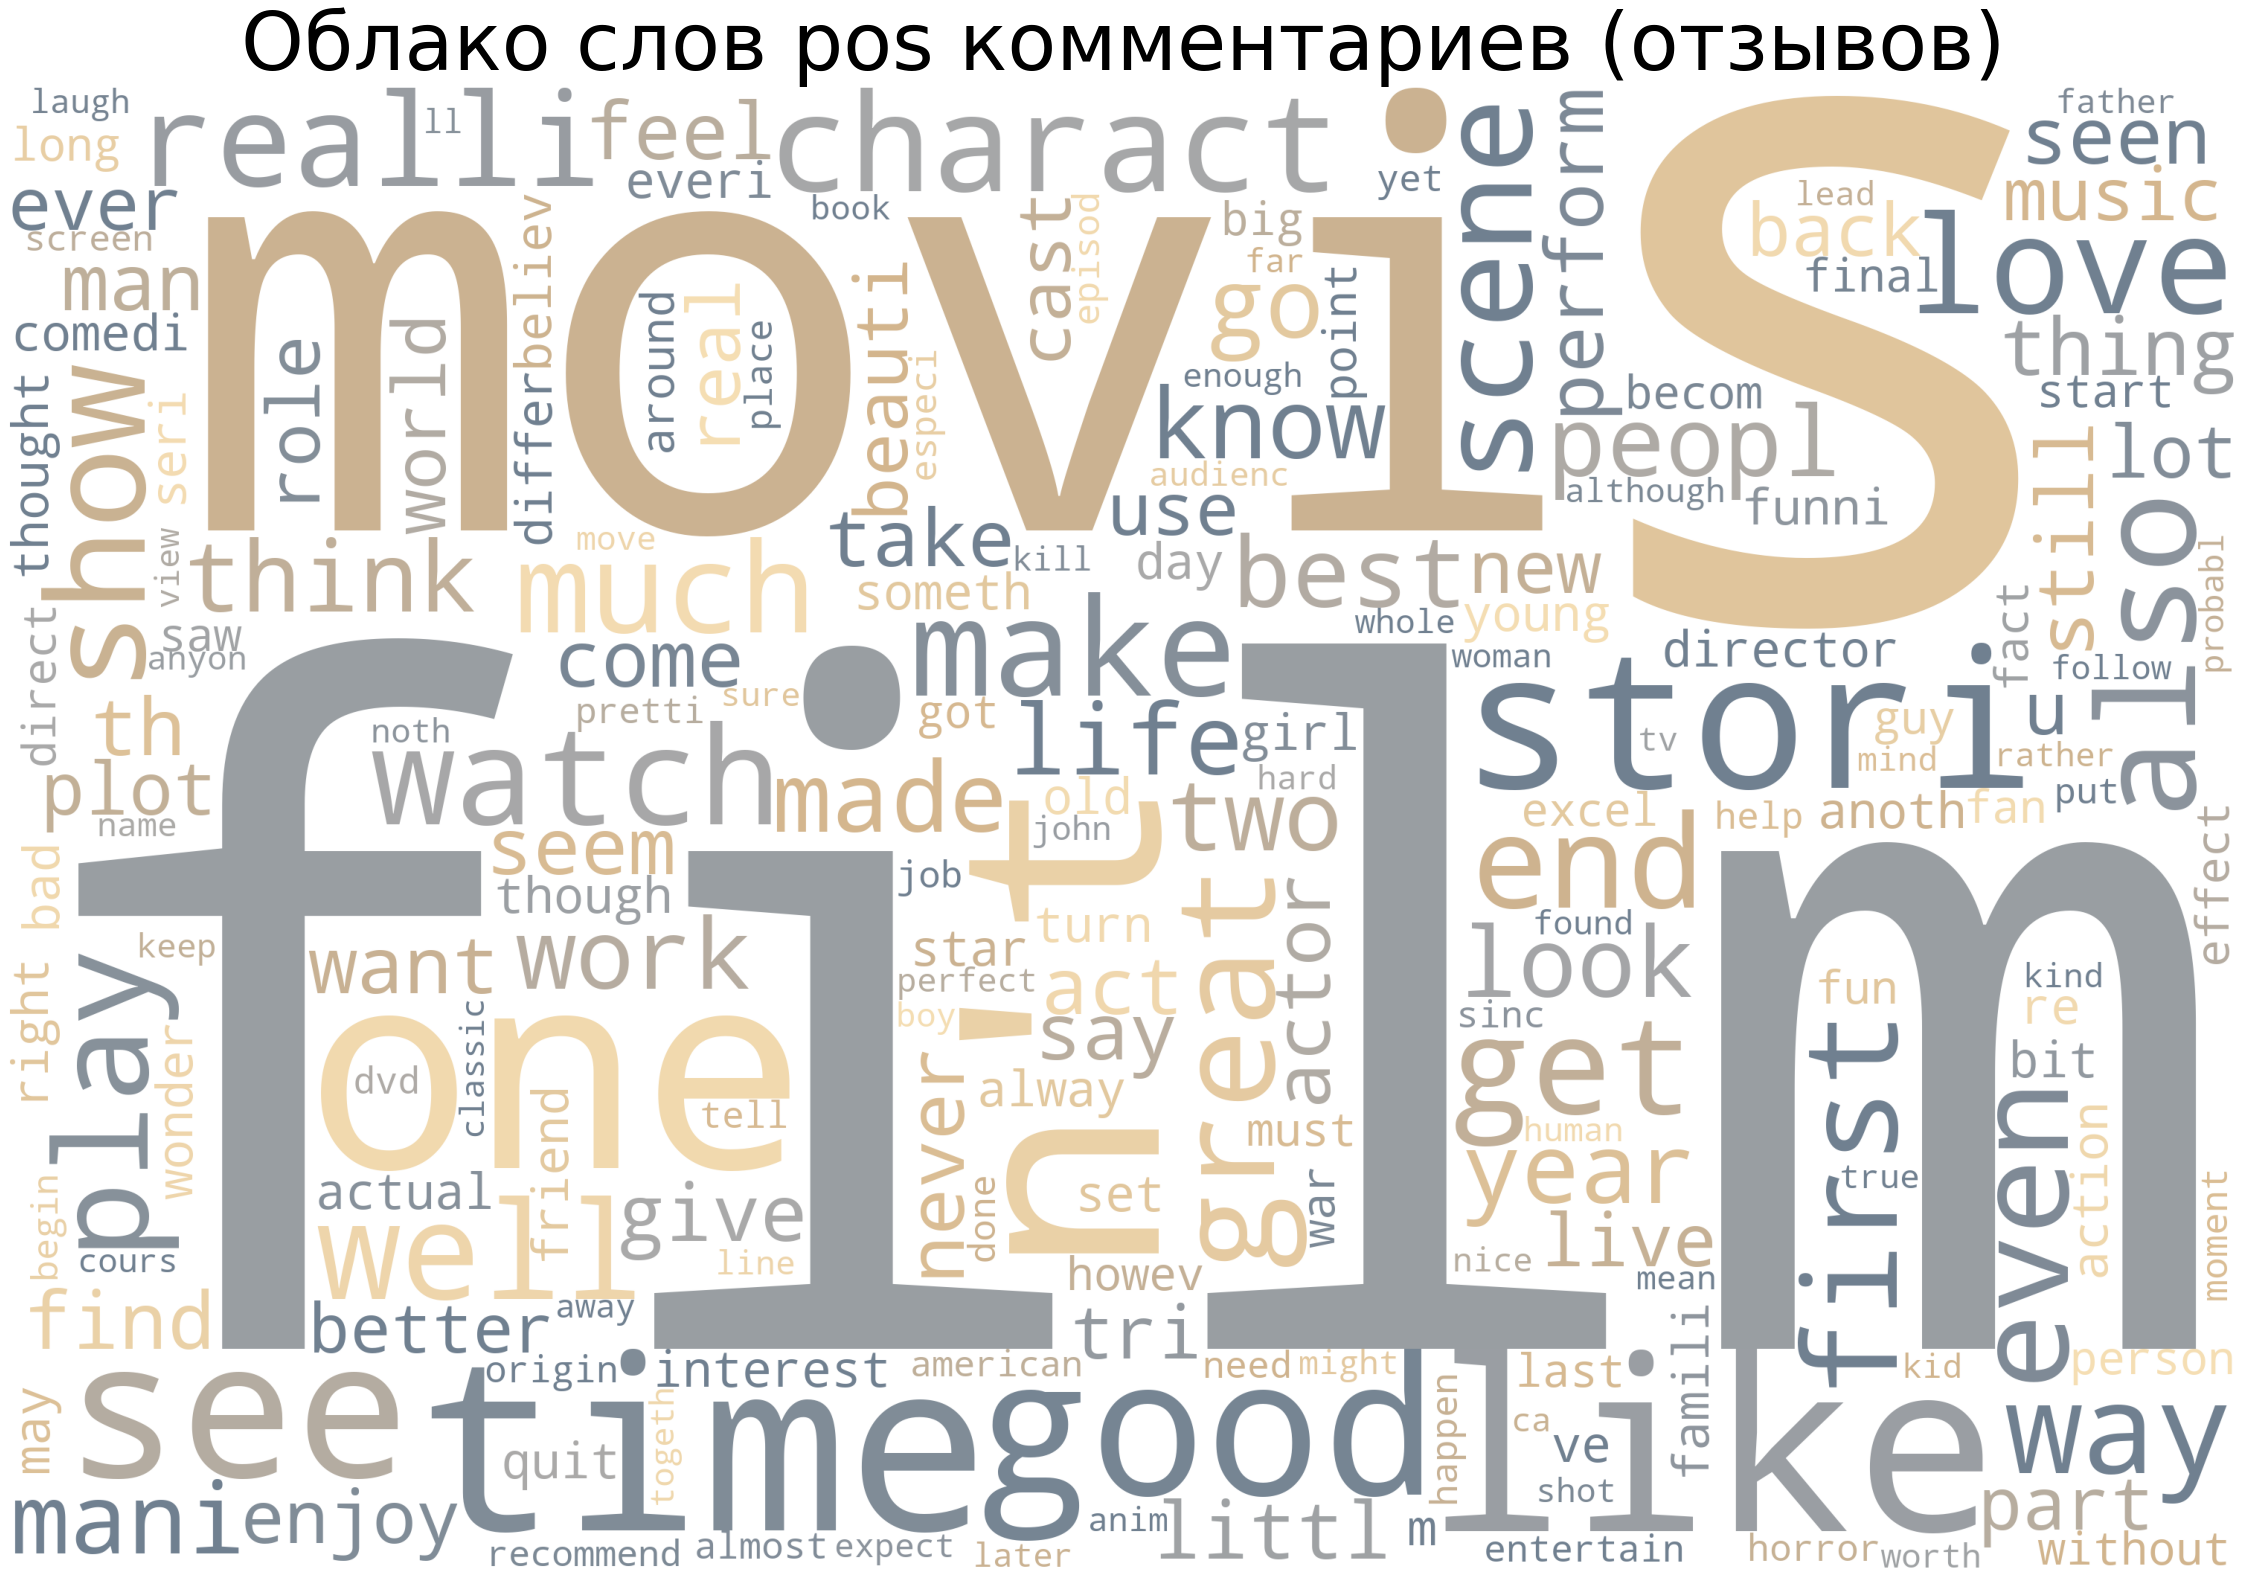

In [415]:
# визуализация сформированного облака слов
plot_cloud(wordcloud_pos, 'pos')

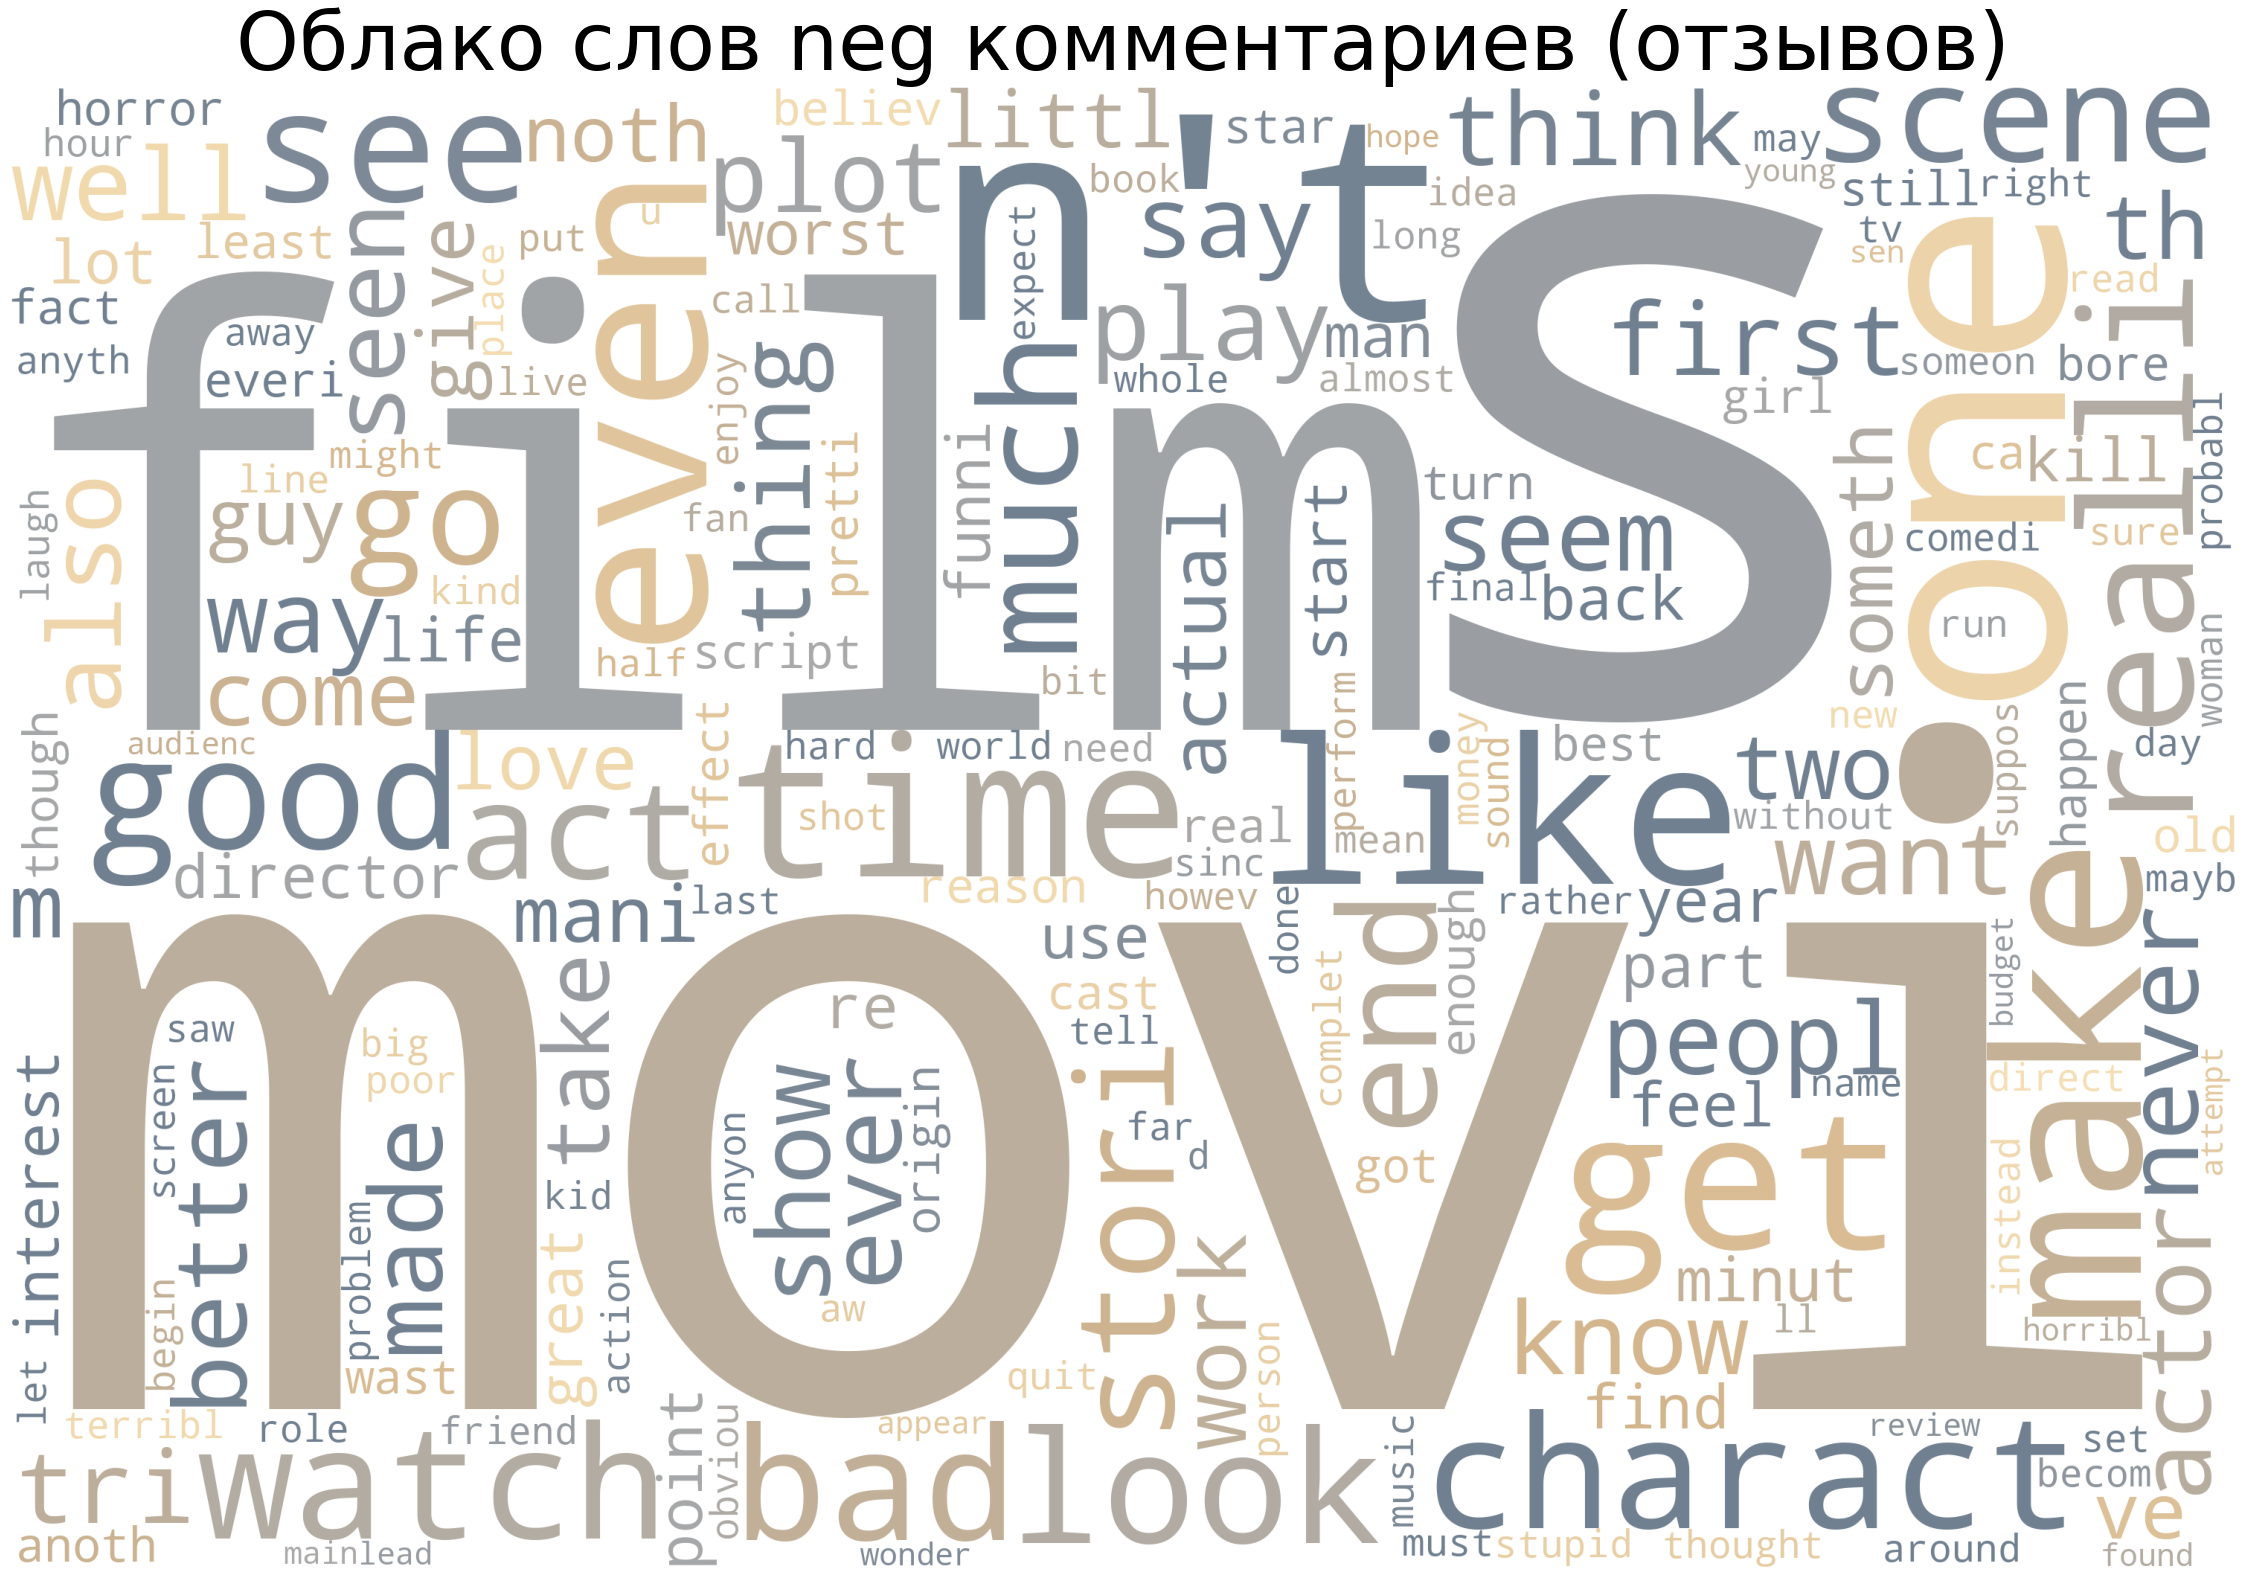

In [416]:
# визуализация сформированного облака слов
plot_cloud(wordcloud_neg, 'neg')

Слова **"movi", "film"**, множественное окончание **"s"**, \
а так же отрицание "n't" являются нерелеватными

In [417]:
# количество общих слов
len(wordcloud_pos.words_.keys() & wordcloud_neg.words_.keys())

163

In [404]:
# количество слов, которые есть только в положительных комментариях (отзывах)
len(wordcloud_pos.words_.keys() - wordcloud_neg.words_.keys())

37

In [406]:
wordcloud_pos.words_.keys() - wordcloud_neg.words_.keys()

{'although',
 'alway',
 'american',
 'anim',
 'beauti',
 'boy',
 'classic',
 'cours',
 'differ',
 'dvd',
 'entertain',
 'episod',
 'especi',
 'excel',
 'famili',
 'father',
 'follow',
 'fun',
 'help',
 'human',
 'job',
 'john',
 'keep',
 'later',
 'mind',
 'moment',
 'move',
 'nice',
 'perfect',
 'recommend',
 'seri',
 'togeth',
 'true',
 'view',
 'war',
 'worth',
 'yet'}

In [418]:
# количество слов, которые есть только в негативных комментариях (отзывах)
len(wordcloud_neg.words_.keys() - wordcloud_pos.words_.keys())

37

In [407]:
wordcloud_neg.words_.keys() - wordcloud_pos.words_.keys()

{'anyth',
 'appear',
 'attempt',
 'aw',
 'bore',
 'budget',
 'call',
 'complet',
 'd',
 'half',
 'hope',
 'horribl',
 'hour',
 'idea',
 'instead',
 'least',
 'let',
 'main',
 'mayb',
 'minut',
 'money',
 'obviou',
 'poor',
 'problem',
 'read',
 'reason',
 'review',
 'run',
 'script',
 'sen',
 'someon',
 'sound',
 'stupid',
 'suppos',
 'terribl',
 'wast',
 'worst'}

# Выгрузка данных

In [419]:
# выгрузка данных
cursor.execute("""SELECT data_name, label_name, rating, review \
                  FROM sentiment
                  INNER JOIN label ON label.id = sentiment.label_id
                  INNER JOIN data ON data.id = sentiment.data_id
                  WHERE rating > 0;""")
sentiments = cursor.fetchall()
# преобразование в DataFrame
df_sentiments = pd.DataFrame(sentiments, columns=[_.name for _ in cursor.description])
df_sentiments.head()

,data_name,label_name,rating,review
0,train,pos,8,"I do try not to take IMDb ratings to heart, bu..."
1,train,pos,8,"I saw this when it first came to video, my lit..."
2,train,pos,10,its great i loved it ha cause i love dinosaurs...
3,train,pos,7,"I wouldn't call ""We're Back! A Dinosaur's Stor..."
4,train,pos,10,this was a personal favorite of mine when i wa...


In [420]:
# проверка на наличие пропусков
df_sentiments.isna().sum()

data_name     0
label_name    0
rating        0
review        0
dtype: int64

Пропусков в данных **нет**

In [421]:
# проверка соответствия типа данных
df_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data_name   50000 non-null  object
 1   label_name  50000 non-null  object
 2   rating      50000 non-null  int64 
 3   review      50000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


Тип данных **соответствует** значению

In [422]:
# размерность данных
df_sentiments.shape

(50000, 4)

In [423]:
# вывод данных
df_sentiments.head()

,data_name,label_name,rating,review
0,train,pos,8,"I do try not to take IMDb ratings to heart, bu..."
1,train,pos,8,"I saw this when it first came to video, my lit..."
2,train,pos,10,its great i loved it ha cause i love dinosaurs...
3,train,pos,7,"I wouldn't call ""We're Back! A Dinosaur's Stor..."
4,train,pos,10,this was a personal favorite of mine when i wa...


In [424]:
# сохранение в файл
df_sentiments.to_csv('data/sentiments.csv', index=False)